In [12]:
from imagem import Imagem
from glob import glob
import Functions as fc
import numpy as np
from skimage.io import imread,imshow,imsave,imread_collection
import cv2
from skimage.exposure import equalize_hist
from skimage.filters import median
from IPython.display import clear_output
from tqdm import tqdm
import seaborn as sns
import time
from sklearn.decomposition import PCA
from skimage.feature import greycomatrix, greycoprops
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
originais = sorted(glob(f'./imagens/*/*', recursive=True))

imgs = {
    'daisy': sorted(glob(f'./imagens/daisy/*', recursive=True)),
    'dandelion': sorted(glob(f'./imagens/dandelion/*', recursive=True)),
    'rose': sorted(glob(f'./imagens/rose/*', recursive=True)),
    'sunflower': sorted(glob(f'./imagens/sunflower/*', recursive=True)),
    'tulip': sorted(glob(f'./imagens/tulip/*', recursive=True))
}

In [3]:
def poeInt(imagem):
    linhas, colunas = imagem.shape
    copy = np.zeros((linhas, colunas), dtype=np.uint8)
    for l in range(linhas):
        for c in range(colunas):
                if imagem[l][c] == True:
                    copy[l][c] = 255
    return copy

In [4]:
def lerTodos(originais):
    imgs = []
    for i in tqdm(originais, desc='Imagens:  '):
        img = Imagem(i)
        img.ler()
        img.filtros['eq'] = img.equalize()
        img.filtros['median'] = median(img.filtros['eq'] )
        imgs.append(img)
    
    return imgs

In [5]:
def subtraiCamada(img, camada='b'):
    img0 = img.filtros['median'].copy()
    img0 = img0/255
    img0 = img0[:,:,0] + img0[:,:,1] + img0[:,:,2]

    img1 = img.filtros['otsu'][camada].copy()
    img1 = img1/255

    img0[~img1.astype(bool)] = 0
    
    return img0

In [6]:
def subtrai(imgs):
    for i in tqdm(imgs, desc='Otsu:  '):
        i.filtros['otsu'] = {
            'r': poeInt(fc.aplicaOtsu(i.filtros['median'][:,:,0])),
            'g': poeInt(fc.aplicaOtsu(i.filtros['median'][:,:,1])),
            'b': poeInt(fc.aplicaOtsu(i.filtros['median'][:,:,2]))
        }

        i.filtros['inteiro'] = i.inteiro()

        i.filtros['normalize'] = i.normalize()

        i.filtros['sub'] = {
            'r': subtraiCamada(i, 'r'),
            'g': subtraiCamada(i, 'g'),
            'b': subtraiCamada(i, 'b')
        }

        """ 
            Fazer a subtração dos canais de cor com o otsu.     
        """
    
    return imgs


In [7]:
imagens = lerTodos(originais)

Imagens:  : 100%|██████████| 500/500 [00:39<00:00, 12.69it/s]


In [8]:
imagens = subtrai(imagens)

Otsu:  : 100%|██████████| 500/500 [01:24<00:00,  5.95it/s]


In [19]:
def apresenta(imgs, letras, color='gray'):
    _, ax = plt.subplots(1, len(imgs), figsize=(20, 20), sharex=True)
    for index, i in enumerate(ax):
        i.imshow(imgs[index], cmap=color)
        i.set_title(letras[index])
        i.axis('off')

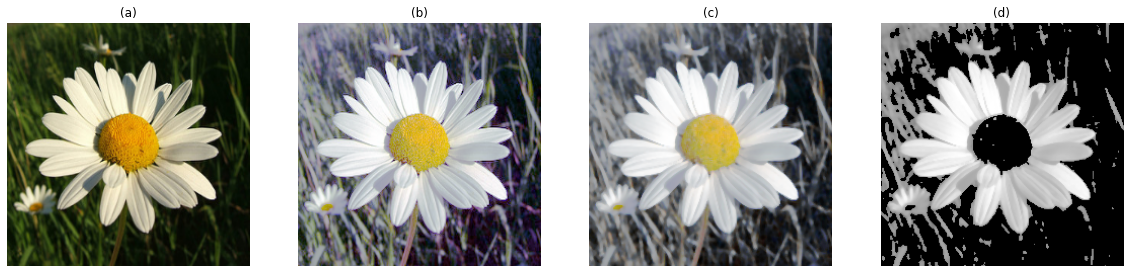

In [21]:
ind = 9
""" Imagem.manyShowWithTitle(
    {'img': imagens[ind].filtros['inteiro'], 'title': 'Original'},
    {'img': imagens[ind].filtros['inteiro'], 'title': 'Original'},
    {'img': imagens[ind].filtros['eq'], 'title': 'Equalize'},
    {'img': imagens[ind].filtros['median'], 'title': 'Median'},
    {'img': imagens[ind].filtros['sub']['b'], 'title': 'Otsu'},
) """

apresenta([
    imagens[ind].filtros['inteiro'],
    imagens[ind].filtros['eq'],
    imagens[ind].filtros['median'],
    imagens[ind].filtros['sub']['b']
], ['(a)', '(b)', '(c)', '(d)'])


#imshow(imagens[5].filtros['sub']['b'], cmap='gray')

In [18]:
auxR = [ imagens[x].filtros['sub']['b'] for x in range(len(imagens)) ]
auxG = [ imagens[x].filtros['sub']['g'] for x in range(len(imagens)) ]
auxB = [ imagens[x].filtros['sub']['r'] for x in range(len(imagens)) ]

In [12]:
""" imagens[0].salvar(auxR, originais, caminho='./subs/red')
imagens[0].salvar(auxG, originais, caminho='./subs/green')
imagens[0].salvar(auxB, originais, caminho='./subs/blue') """

In [19]:
red = imread_collection(sorted(glob(f'./subs/red/*/*', recursive=True)))
green = imread_collection(sorted(glob(f'./subs/green/*/*', recursive=True)))
blue = imread_collection(sorted(glob(f'./subs/blue/*/*', recursive=True)))

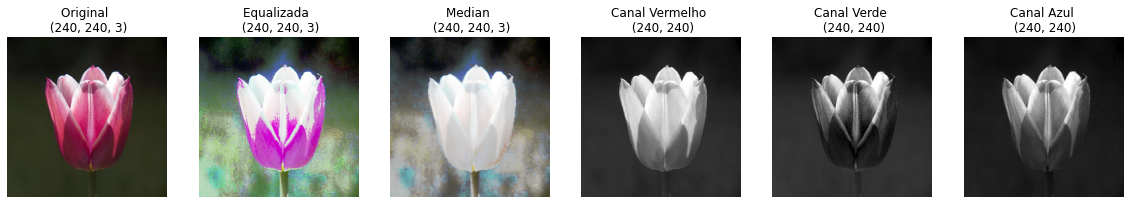

In [27]:
imagens[440].shows(5)

In [28]:
labels = []
labelsInt = []
k = 0
for j in ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']:
    for i in range(100):
        labels.append(j)
        labelsInt.append(k)
    k += 1

---
# Descritores

In [29]:
def aplicaGLCM(images, labels):
    features = np.zeros((len(labels),18)) #6 features x 3 color channels
    start = time.time()
    d = 5
    for id_im,imagem in enumerate(images):
        clear_output(wait=True)
        print('Extraindo atributos: {} imagens processadas de {}.'.format(id_im+1,len(images)))
        for id_ch in range(3):
            matrix0 = greycomatrix(imagem[:,:,id_ch], [d], [0],normed=True)
            matrix1 = greycomatrix(imagem[:,:,id_ch], [d], [np.pi/4],normed=True)
            matrix2 = greycomatrix(imagem[:,:,id_ch], [d], [np.pi/2],normed=True)
            matrix3 = greycomatrix(imagem[:,:,id_ch], [d], [3*np.pi/4],normed=True)
            matrix = (matrix0+matrix1+matrix2+matrix3)/4 
            props = np.zeros((6))
            props[0] = greycoprops(matrix,'contrast')
            props[1] = greycoprops(matrix,'dissimilarity')
            props[2] = greycoprops(matrix,'homogeneity')
            props[3] = greycoprops(matrix,'energy')
            props[4] = greycoprops(matrix,'correlation')
            props[5] = greycoprops(matrix,'ASM')
            features[id_im,id_ch*6:(id_ch+1)*6] = props

    end = time.time()
    tempo = end - start
    clear_output(wait=True)
    return features, tempo

In [ ]:
rRed, tempo = aplicaGLCM(red, labels)
rGreen, tempo = aplicaGLCM(green, labels)
rBlue, tempo = aplicaGLCM(blue, labels)

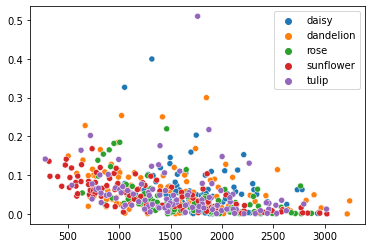

In [36]:
sns.scatterplot(x=rRed[:,0], y=rRed[:,5], hue=labels);

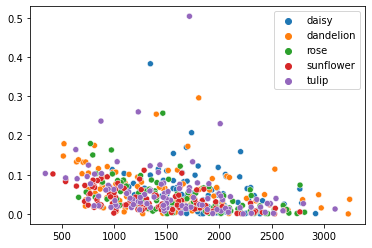

In [35]:
sns.scatterplot(x=rGreen[:,0], y=rGreen[:,5], hue=labels);

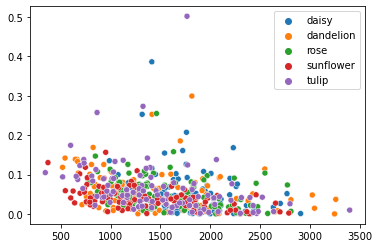

In [34]:
sns.scatterplot(x=rBlue[:,0], y=rBlue[:,5], hue=labels);

In [37]:
def aplicaPCA(features):
    pca = PCA()
    pca.fit(features)
    transform = pca.transform(features)
    print(np.sum(pca.explained_variance_ratio_[0:3]))
    return transform

In [38]:
transRed = aplicaPCA(rRed)
transGreen = aplicaPCA(rGreen)
transBlue = aplicaPCA(rBlue)

0.9999983544615109
0.9999990357781031
0.999998853121441


# Classification

- Dividir o espaço de atributos em regiões;
- A quantidade de regiões é o número de classes;
- A acurácia da classificação está diretamente liga à qualidade dos atributos.

### Train/Test

In [39]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix,accuracy_score
from sklearn.svm import SVC

In [40]:
def classificationForest(X,y, t=0.9):
    """ com random forest """
    # separar conjuntos de treino e teste
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=t,shuffle=True, random_state=42)
    # criar instancia do classificador
    clf = RandomForestClassifier()
    # treinar o classificador
    clf.fit(X_train,y_train)
    # realizar a predicao
    pred = clf.predict(X_test)
    # calcular o resultado utilizando a acuracia
    acuracia = acc(y_test,pred)
    return acuracia

In [41]:
def classificationXBR(X, y, t=0.9):
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=t,shuffle=True)
    # criar instancia do classificador
    clf = xgb.XGBClassifier()
    # treinar o classificador
    clf.fit(X_train,y_train)
    # realizar a predicao
    pred = clf.predict(X_test)
    # calcular o resultado utilizando a acuracia
    acuracia = acc(y_test,pred)
    return acuracia

In [42]:
rRedAc = []
for i in [0.6, 0.7, 0.8, 0.9]:
    rRedAc.append(
        {
            "Original": {
                'rf': classificationForest(rRed, labelsInt, t=i),
                'xbr': classificationXBR(rRed, labelsInt, t=i)
            },
            "Transform": {
                'rf': classificationForest(transRed, labelsInt, t=i),
                'xbr': classificationXBR(transRed, labelsInt, t=i)
            }
        }
    )

rRedAc

[{'Original': {'rf': 0.435, 'xbr': 0.435},
  'Transform': {'rf': 0.53, 'xbr': 0.48}},
 {'Original': {'rf': 0.41333333333333333, 'xbr': 0.43333333333333335},
  'Transform': {'rf': 0.5266666666666666, 'xbr': 0.5533333333333333}},
 {'Original': {'rf': 0.51, 'xbr': 0.48},
  'Transform': {'rf': 0.55, 'xbr': 0.59}},
 {'Original': {'rf': 0.48, 'xbr': 0.54},
  'Transform': {'rf': 0.58, 'xbr': 0.48}}]

In [43]:
rGreenAc = []
for i in [0.6, 0.7, 0.8, 0.9]:
    rGreenAc.append(
        {
            "Original": {
                'rf': classificationForest(rGreen, labelsInt, t=i),
                'xbr': classificationXBR(rGreen, labelsInt, t=i)
            },
            "Transform": {
                'rf': classificationForest(transGreen, labelsInt, t=i),
                'xbr': classificationXBR(transGreen, labelsInt, t=i)
            }
        }
    )

rGreenAc

[{'Original': {'rf': 0.375, 'xbr': 0.39},
  'Transform': {'rf': 0.575, 'xbr': 0.52}},
 {'Original': {'rf': 0.44, 'xbr': 0.4533333333333333},
  'Transform': {'rf': 0.58, 'xbr': 0.5466666666666666}},
 {'Original': {'rf': 0.44, 'xbr': 0.48},
  'Transform': {'rf': 0.54, 'xbr': 0.62}},
 {'Original': {'rf': 0.56, 'xbr': 0.48},
  'Transform': {'rf': 0.56, 'xbr': 0.48}}]

In [44]:
rBlueAc = []
for i in [0.6, 0.7, 0.8, 0.9]:
    rBlueAc.append(
        {
            "Original": {
                'rf': classificationForest(rBlue, labelsInt, t=i),
                'xbr': classificationXBR(rBlue, labelsInt, t=i)
            },
            "Transform": {
                'rf': classificationForest(transBlue, labelsInt, t=i),
                'xbr': classificationXBR(transBlue, labelsInt, t=i)
            }
        }
    )

rBlueAc

[{'Original': {'rf': 0.47, 'xbr': 0.485},
  'Transform': {'rf': 0.55, 'xbr': 0.565}},
 {'Original': {'rf': 0.5, 'xbr': 0.4533333333333333},
  'Transform': {'rf': 0.5933333333333334, 'xbr': 0.5933333333333334}},
 {'Original': {'rf': 0.44, 'xbr': 0.52},
  'Transform': {'rf': 0.56, 'xbr': 0.52}},
 {'Original': {'rf': 0.48, 'xbr': 0.52},
  'Transform': {'rf': 0.54, 'xbr': 0.6}}]

# Grid Seach

In [45]:
def aplicaGS_randomForest(imgs, labels, test_size=0.20):
    #para treinar o classificador
    x_train, x_test, y_train, y_test = train_test_split(imgs,labels, test_size=test_size, random_state=42)

    #criar instancia do classificador
    clf = RandomForestClassifier()

    #definir os parametros a serem testados
    param_grid = {
        'n_estimators': [100,110,120,150,200]
    }

    #criar instancia do grid search
    grid = GridSearchCV(
        clf,
        param_grid,
        scoring = 'accuracy',
        cv = 5
        #n_jobs=-1
    )

    #treinar o classificador
    grid.fit(x_train, y_train)

    return grid.best_params_

In [46]:
def aplicaGS_xbr(imgs, labels, test_size=0.2):
    #para treinar o classificador
    x_train, x_test, y_train, y_test = train_test_split(imgs,labels, test_size=test_size, random_state=42)

    #criar instancia do classificador
    clf = xgb.XGBClassifier()



    #definir os parametros a serem testados
    param_grid = {
        'n_estimators': [100,110,120,150,200]
    }

    #criar instancia do grid search
    grid = GridSearchCV(
        clf,
        param_grid,
        scoring = 'accuracy',
        cv = 5
        #n_jobs=-1
    )

    #treinar o classificador
    grid.fit(x_train, y_train)

    return grid.best_params_

In [48]:
redParams = {
    'rf': aplicaGS_randomForest(rRed, labelsInt),
    'xbr': aplicaGS_xbr(rRed, labelsInt),
    'rf_transform': aplicaGS_randomForest(transRed, labelsInt),
    'xbr_transform': aplicaGS_xbr(transRed, labelsInt)
}

greenParams = {
    'rf': aplicaGS_randomForest(rGreen, labelsInt),
    'xbr': aplicaGS_xbr(rGreen, labelsInt),
    'rf_transform': aplicaGS_randomForest(transGreen, labelsInt),
    'xbr_transform': aplicaGS_xbr(transGreen, labelsInt)
}

blueParams = {
    'rf': aplicaGS_randomForest(rBlue, labelsInt),
    'xbr': aplicaGS_xbr(rBlue, labelsInt),
    'rf_transform': aplicaGS_randomForest(transBlue, labelsInt),
    'xbr_transform': aplicaGS_xbr(transBlue, labelsInt)
}

In [50]:
redParams,greenParams,blueParams

({'rf': {'n_estimators': 120},
  'xbr': {'n_estimators': 110},
  'rf_transform': {'n_estimators': 200},
  'xbr_transform': {'n_estimators': 100}},
 {'rf': {'n_estimators': 200},
  'xbr': {'n_estimators': 150},
  'rf_transform': {'n_estimators': 100},
  'xbr_transform': {'n_estimators': 200}},
 {'rf': {'n_estimators': 100},
  'xbr': {'n_estimators': 100},
  'rf_transform': {'n_estimators': 200},
  'xbr_transform': {'n_estimators': 200}})

# Cross Validation

## Random Forest

In [52]:
def crossValidationRF(imgs, labels, bestPrms, test=0.3):
    # para treinar o classificador
    x_train, x_test, y_train, y_test = train_test_split(imgs,labels, test_size=test, random_state=42)
    
    # criar instancia do classificador
    clf = RandomForestClassifier(n_estimators=bestPrms['rf']['n_estimators'])
    
    # treinar o classificador
    clf.fit(x_train, y_train)

    # realizar a predicao
    pred = clf.predict(x_test)

    # calcular o resultado utilizando a acuracia
    acuracia = acc(y_test,pred)

    # Criar as métricas
    metrics = ['accuracy','precision_macro','recall_macro','f1_macro']

    # Criar o dicionário de resultados
    scores_rf = cross_validate(clf, imgs, labels, cv=5, scoring=metrics)

    # Criar o dicionário de resultados
    kappa = make_scorer(cohen_kappa_score)

    
    scores_rf_kappa = cross_validate(clf,imgs,labels,cv=5, scoring=kappa)


    clear_output(wait=True)


    return acuracia, scores_rf, scores_rf_kappa

#### RED

In [92]:
acRf_Red, scoresRf_Red, scoresRfKappa_Red = crossValidationRF(rRed, labelsInt, redParams)
acRf_Red_trans, scoresRf_Red_trans, scoresRfKappa_Red_Trans = crossValidationRF(transRed, labelsInt, redParams)

In [85]:
acRf_Red, acRf_Red_trans 

(0.42, 0.5266666666666666)

In [93]:
pd.DataFrame(scoresRf_Red)

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,0.127305,0.008261,0.43,0.417256,0.43,0.422045
1,0.129710,0.007375,0.45,0.449814,0.45,0.447936
2,0.134294,0.008397,0.44,0.463274,0.44,0.434545
3,0.133227,0.007592,0.43,0.402424,0.43,0.412468
4,0.134949,0.009679,0.47,0.470666,0.47,0.467798


In [94]:
pd.DataFrame(scoresRf_Red_trans)

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,0.157108,0.007407,0.58,0.547144,0.58,0.553084
1,0.129239,0.007545,0.60,0.627731,0.60,0.586049
2,0.124648,0.007082,0.51,0.510827,0.51,0.506146
3,0.130596,0.008219,0.49,0.470368,0.49,0.474552
4,0.123138,0.007936,0.49,0.500826,0.49,0.492201


In [95]:
pd.DataFrame(data=scoresRfKappa_Red)

,fit_time,score_time,test_score
0,0.138168,0.007125,0.2875
1,0.137353,0.006650,0.2750
2,0.131721,0.006954,0.3000
3,0.125805,0.007377,0.2625
4,0.137058,0.006727,0.3750


In [96]:
pd.DataFrame(data=scoresRfKappa_Red_Trans)

,fit_time,score_time,test_score
0,0.123143,0.006536,0.4750
1,0.125233,0.006761,0.4625
2,0.127506,0.007599,0.3375
3,0.137773,0.006834,0.2875
4,0.135967,0.007404,0.3625


In [107]:
scoresRfKappa_Red['test_score'].mean(), scoresRfKappa_Red['test_score'].std()

(0.3, 0.03952847075210475)

In [99]:
scoresRfKappa_Red_Trans['test_score'].mean(), scoresRfKappa_Red_Trans['test_score'].std() 

(0.385, 0.07262919523166975)

#### GREEN

In [100]:
acRf_Green, scoresRf_Green, scoresRfKappa_Green = crossValidationRF(rGreen, labelsInt, greenParams)
acRf_Green_trans, scoresRf_Green_trans, scoresRfKappa_Green_Trans = crossValidationRF(transGreen, labelsInt, greenParams)

In [101]:
acRf_Green, acRf_Green_trans

(0.4266666666666667, 0.58)

In [102]:
pd.DataFrame(scoresRf_Green)

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,0.218111,0.011081,0.37,0.343077,0.37,0.351924
1,0.204741,0.011562,0.35,0.361949,0.35,0.355209
2,0.211976,0.011703,0.37,0.389679,0.37,0.377185
3,0.211251,0.012797,0.38,0.355098,0.38,0.364126
4,0.238290,0.011974,0.35,0.326923,0.35,0.332714


In [103]:
pd.DataFrame(scoresRf_Green_trans)

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,0.200891,0.011757,0.52,0.481469,0.52,0.488710
1,0.203625,0.011700,0.56,0.582618,0.56,0.563105
2,0.206858,0.012947,0.49,0.478236,0.49,0.478140
3,0.210332,0.011054,0.52,0.506108,0.52,0.509202
4,0.199872,0.011741,0.56,0.549739,0.56,0.553448


In [104]:
pd.DataFrame(scoresRfKappa_Green)

,fit_time,score_time,test_score
0,0.204455,0.010457,0.2375
1,0.202594,0.010891,0.1750
2,0.203673,0.010929,0.2625
3,0.205972,0.011075,0.2750
4,0.205284,0.011272,0.1875


In [105]:
pd.DataFrame(scoresRfKappa_Green_Trans)

,fit_time,score_time,test_score
0,0.212404,0.010334,0.3750
1,0.208565,0.011432,0.4500
2,0.228708,0.013421,0.3750
3,0.229980,0.013709,0.4500
4,0.229913,0.010946,0.4375


In [106]:
scoresRfKappa_Green['test_score'].mean(), scoresRfKappa_Green['test_score'].std()

(0.22750000000000004, 0.039843443626273053)

In [108]:
scoresRfKappa_Green_Trans['test_score'].mean(), scoresRfKappa_Green_Trans['test_score'].std()

(0.4175, 0.03499999999999998)

#### BLUE

In [109]:
acRf_Blue, scoresRf_Blue, scoresRfKappa_Blue = crossValidationRF(rBlue, labelsInt, blueParams)
acRf_Blue_trans, scoresRf_Blue_trans, scoresRfKappa_Blue_Trans = crossValidationRF(transBlue, labelsInt, blueParams)

In [110]:
acRf_Blue, acRf_Blue_trans

(0.44666666666666666, 0.5666666666666667)

In [111]:
pd.DataFrame(scoresRf_Blue)

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,0.139972,0.006059,0.44,0.438060,0.44,0.434162
1,0.107944,0.009810,0.43,0.436595,0.43,0.431996
2,0.113201,0.006369,0.40,0.431695,0.40,0.413921
3,0.101989,0.006617,0.49,0.516401,0.49,0.489541
4,0.103572,0.006992,0.42,0.412856,0.42,0.415968


In [112]:
pd.DataFrame(scoresRf_Blue_trans)

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,0.118579,0.007289,0.56,0.551904,0.56,0.554305
1,0.119189,0.006720,0.54,0.510979,0.54,0.511477
2,0.106135,0.008048,0.44,0.434947,0.44,0.436141
3,0.104380,0.006885,0.51,0.508074,0.51,0.504680
4,0.100545,0.005990,0.55,0.544134,0.55,0.544659


In [113]:
pd.DataFrame(scoresRfKappa_Blue)

,fit_time,score_time,test_score
0,0.104412,0.005453,0.3750
1,0.104128,0.005760,0.3125
2,0.102664,0.005641,0.2000
3,0.101810,0.006228,0.3250
4,0.107585,0.006167,0.2625


In [115]:
pd.DataFrame(scoresRfKappa_Blue_Trans)

,fit_time,score_time,test_score
0,0.104129,0.006471,0.4250
1,0.106608,0.006211,0.4375
2,0.104975,0.005507,0.3125
3,0.101470,0.006061,0.4375
4,0.102269,0.005287,0.4625


In [116]:
scoresRfKappa_Blue['test_score'].mean(), scoresRfKappa_Blue['test_score'].std()

(0.295, 0.05947688626685161)

In [117]:
scoresRfKappa_Blue_Trans['test_score'].mean(), scoresRfKappa_Blue_Trans['test_score'].std()

(0.41500000000000004, 0.0526782687642637)